In [25]:
%matplotlib inline
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import rosbag
import scipy.optimize
from angles import normalize_angle, shortest_angular_distance
from numpy import sin, cos
from tf.transformations import translation_matrix, quaternion_matrix, inverse_matrix, translation_from_matrix, \
    euler_from_matrix, euler_matrix, identity_matrix
from tf2_ros import ExtrapolationException
from tf_bag import BagTfTransformer


# bag_file_path = '/home/ramon/2021-02-26-13-55-27_filtered.bag'
# bag_file_path = '/home/ramon/2021-03-04-13-40-17_error.bag'
# bag_file_path = '/home/ramon/2021-03-04-13-29-35_tuned.bag'
# bag_file_path = '/home/ramon/2021-03-05-13-43-38_linear_error.bag'
bag_file_path = '/home/ramon/2021-03-05-14-30-29_angle_error.bag'

bag = rosbag.Bag(bag_file_path)
bag_transformer = BagTfTransformer(bag)

In [26]:
def to_matrix(data):
    t = translation_matrix(data[0])
    r = quaternion_matrix(data[1])
    return np.dot(t, r)


@dataclass
class DataPoint:
    timestamp: str
    ground_truth: float
    measurement: int = 0


data = []
for _, msg, _ in bag.read_messages(topics=['/scan']):
    try:
        ground_truth = bag_transformer.lookupTransform('map', 'base_link', msg.header.stamp)
        measurement = bag_transformer.lookupTransform('odom', 'base_link', msg.header.stamp)
    except ExtrapolationException:
        continue
    ground_truth = to_matrix(ground_truth)
    measurement = to_matrix(measurement)
    data.append(DataPoint(timestamp=msg.header.stamp, ground_truth=ground_truth, measurement=measurement))

print(len(data), 'data points')
# newdata = [data[0]]
# for d in data:
#     if np.linalg.norm(translation_from_matrix(d.measurement) - translation_from_matrix(newdata[-1].measurement)) > 0.2:
#         newdata.append(d)
# data = newdata
data = data[::5]
print(len(data), 'data points')

594 data points
119 data points


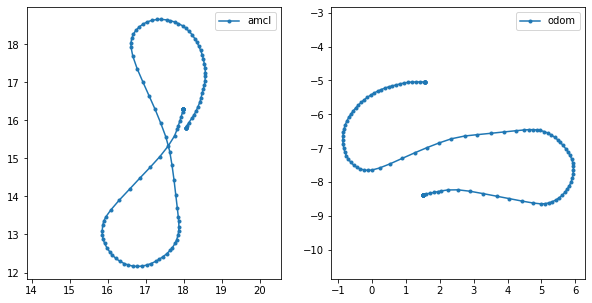

In [27]:
ground_truth = np.array([translation_from_matrix(d.ground_truth) for d in data])
measurement = np.array([translation_from_matrix(d.measurement) for d in data])

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(ground_truth[:, 0], ground_truth[:, 1], '.-', label='amcl')
ax.legend();
ax.axis('equal');

ax = fig.add_subplot(1, 2, 2)
ax.plot(measurement[:, 0], measurement[:, 1], '.-', label='odom');
ax.legend();
ax.axis('equal');

In [28]:
def pairs(seq):
    i = iter(seq)
    prev = next(i)
    for item in i:
        yield prev, item
        prev = item

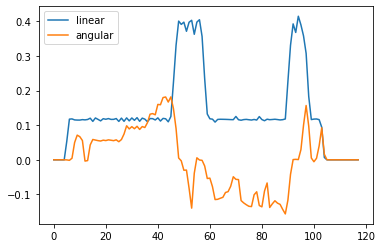

In [29]:
def inverse_odometry(m1, m2):
    delta_measurement = translation_from_matrix(m2) - translation_from_matrix(m1)
    r1 = euler_from_matrix(m1)[2]
    r2 = euler_from_matrix(m2)[2]

    R = np.linalg.lstsq([[sin(r2) - sin(r1)], [-cos(r2) + cos(r1)]], delta_measurement[:2], rcond=None)[0][0]
    angular = normalize_angle(r2 - r1)
    linear = R * angular
    
    return linear, angular

commands = []

for d1, d2 in pairs(data):
    linear, angular = inverse_odometry(d1.measurement, d2.measurement)
    commands.append((linear, angular))

commands = np.array(commands)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(commands[:, 0], label='linear')
ax.plot(commands[:, 1], label='angular')
# ax.set(ylim=(-1.5, 1.5));
ax.legend();

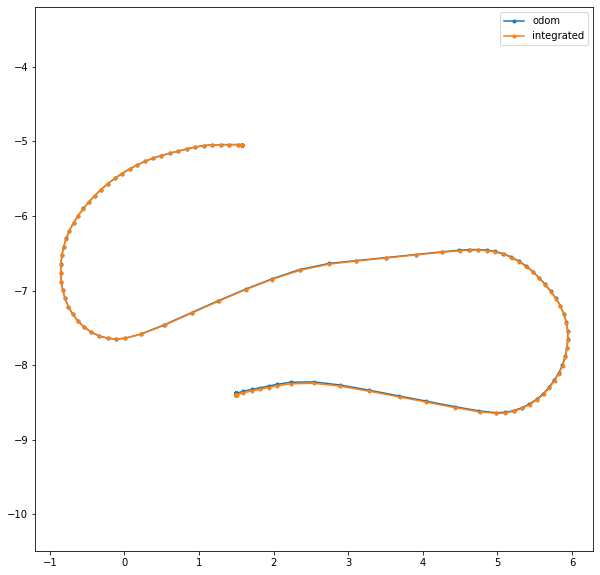

In [30]:
def odometry_runge_kutta2(position, linear, angular):
    x, y = translation_from_matrix(position)[:2]
    heading = euler_from_matrix(position)[2]
    direction = heading + angular * 0.5

    # Runge-Kutta 2nd order integration:
    x += linear * cos(direction)
    y += linear * sin(direction)
    heading += angular
    return x, y, heading
    

def odometry_exact(position, linear, angular):
    # Exact integration (should solve problems when angular is zero):
    x, y = translation_from_matrix(position)[:2]
    heading = euler_from_matrix(position)[2]

    heading_old = heading
    r = linear / angular
    heading += angular
    x += r * (sin(heading) - sin(heading_old))
    y += -r * (cos(heading) - cos(heading_old))
    return x, y, heading


def odometry(position, linear, angular):
    if (abs(angular) < 1e-6):
        x, y, heading = odometry_runge_kutta2(position, linear, angular)
    else:        
        x, y, heading = odometry_exact(position, linear, angular)

    t = translation_matrix((x, y, 0))
    r = euler_matrix(0, 0, heading)
    return np.dot(t, r)


measurements = np.array([translation_from_matrix(d.measurement) for d in data])

positions = [data[0].measurement]
for d1, d2 in pairs(data):
    linear, angular = inverse_odometry(d1.measurement, d2.measurement)
    positions.append(odometry(positions[-1], linear, angular))
positions = np.array([translation_from_matrix(p) for p in positions])


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(measurements[:, 0], measurements[:, 1], '.-', label='odom')
ax.plot(positions[:, 0], positions[:, 1], '.-', label='integrated');
ax.legend();
ax.axis('equal');

In [31]:
def f(x):
    errs = []
    for d1, d2 in pairs(data):
        linear, angular = inverse_odometry(d1.measurement, d2.measurement)
        
        # model parameters
        wheel_separation_multiplier = x[0]
        wheel_radius_multiplier = x[1]

        linear2 = linear * wheel_radius_multiplier
        angular2 = angular * wheel_radius_multiplier / wheel_separation_multiplier
        
        new_pos = odometry(identity_matrix(), linear2, angular2)

        # x and y error
        delta_ground_truth = np.dot(inverse_matrix(d1.ground_truth), d2.ground_truth)
        err_2d = translation_from_matrix(delta_ground_truth)[:2] - translation_from_matrix(new_pos)[:2]
        
        # rotation error
        err_rot = shortest_angular_distance(euler_from_matrix(delta_ground_truth)[2], euler_from_matrix(new_pos)[2])
        errs.append((err_2d[0], err_2d[1], err_rot))
        
    errs = np.array(errs)
    print('err:', np.linalg.norm(errs), x[0], x[1])
    return errs


bounds = (0.5, 2)
result = scipy.optimize.least_squares(lambda x: np.ndarray.flatten(f(x)), [1, 1], bounds=list(zip(bounds, bounds)))
# scipy.optimize.shgo(f, bounds=[(0.5, 1.5), (0.5, 1.5)])
# scipy.optimize.dual_annealing(f, bounds=[(0.5, 1.5), (0.5, 1.5)], maxiter=500, callback=lambda x, f, context: print(x))
# scipy.optimize.brute(f, ranges=[(0.5, 1.5), (0.5, 1.5)])

del result['fun']
del result['jac']
print(result)
print('wheel_separation_multiplier', result.x[0])
print('wheel_radius_multiplier', result.x[1])

err: 0.2626646344712073 1.0 1.0
err: 0.2626646408673331 1.0000000149011612 1.0
err: 0.2626646269466728 1.0 1.0000000149011612
err: 0.2338238021341133 0.9062104313700059 1.0104944299163492
err: 0.2338238030485411 0.9062104462711671 1.0104944299163492
err: 0.23382380257051683 0.9062104313700059 1.0104944449738895
err: 0.23327580455970534 0.8913213829471823 1.0054676057688918
err: 0.23327580457895838 0.8913213978483435 1.0054676057688918
err: 0.23327580457683983 0.8913213829471823 1.0054676207515267
err: 0.23327550561042518 0.8909831671013014 1.0053271660318979
err: 0.23327550561043123 0.8909831820024626 1.0053271660318979
err: 0.2332755056104365 0.8909831671013014 1.00532718101244
err: 0.23327550561038107 0.8909830569973148 1.0053271093210965
err: 0.2332755056103824 0.890983071898476 1.0053271093210965
err: 0.2332755056103847 0.8909830569973148 1.0053271243016377
 active_mask: array([0, 0])
        cost: 0.027208730758889466
        grad: array([1.14406416e-08, 1.93439221e-08])
     mess

err: 0.2626646344712073 1 1
err: 0.23327550561038107 0.8909830569973148 1.0053271093210965


(-0.04858391364777559, 0.05985034319806018)

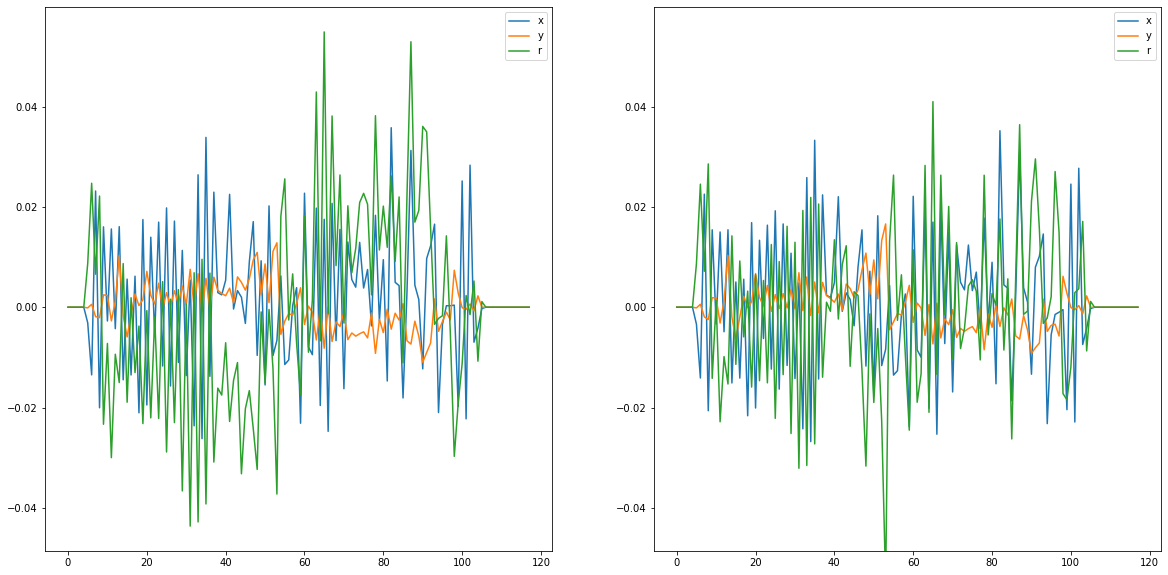

In [32]:
fig = plt.figure(figsize=(20, 10))

original = f((1, 1))
ax = fig.add_subplot(1, 2, 1)
ax.plot(original[:,0], label='x')
ax.plot(original[:,1], label='y')
ax.plot(original[:,2], label='r')
ax.legend();
ylim = ax.get_ylim()

corrected = f(result.x)
ax = fig.add_subplot(1, 2, 2)
ax.plot(corrected[:,0], label='x')
ax.plot(corrected[:,1], label='y')
ax.plot(corrected[:,2], label='r')
ax.legend();
ax.set_ylim(ylim)